In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging

In [198]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [199]:
def generate_rand_weighted_g(node_size=NUM_NODE, p=0.05, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [200]:
G = generate_rand_weighted_g(node_size=NUM_NODE)

print_g(G)

(0, 51, {'weight': 0.8092855335351516})
(0, 46, {'weight': 0.9693463365543081})
(0, 7, {'weight': 0.2362821479405819})
(1, 16, {'weight': 0.655723690789436})
(1, 83, {'weight': 0.17869414290254237})
(1, 75, {'weight': 0.11043018802468452})
(2, 99, {'weight': 0.541543564445612})
(2, 7, {'weight': 0.649567769049794})
(2, 9, {'weight': 0.22171773893091518})
(2, 10, {'weight': 0.8018316999869021})
(2, 76, {'weight': 0.6462412142558103})
(2, 47, {'weight': 0.23127107548542025})
(2, 92, {'weight': 0.6247413115919938})
(2, 18, {'weight': 0.3217725130260154})
(2, 54, {'weight': 0.8004626326449508})
(2, 28, {'weight': 0.5294219661275995})
(2, 61, {'weight': 0.08817323680343248})
(2, 94, {'weight': 0.8399716646390059})
(3, 32, {'weight': 0.23917002062701787})
(3, 98, {'weight': 0.8770356348360253})
(3, 7, {'weight': 0.21975400350595464})
(3, 9, {'weight': 0.16720922054318976})
(3, 75, {'weight': 0.9457122354027503})
(3, 92, {'weight': 0.04027074321252566})
(3, 57, {'weight': 0.9621842441444484})

In [201]:
G.number_of_nodes()

100

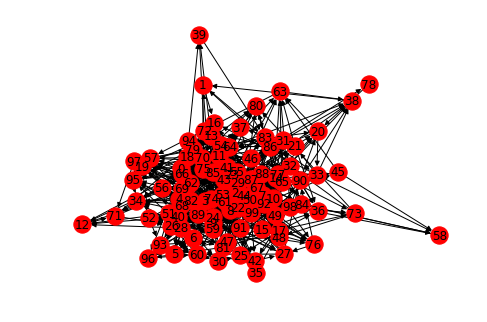

In [202]:
nx.draw(G, with_labels=True)
plt.show()

In [203]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

13

In [204]:
X, y = [], []

def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

for node in G.nodes:
    
    if G.out_degree(node) == 0:
        continue

    init_weight_vec = np.ones(max_out_degree)
    
    for idx, out_edge in enumerate(G.out_edges(node)):
        init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
#     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))
    
#     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
    label = min(out_neighbors, key=lambda d: d[1])[1]
#     print(label, init_weight_vec[np.argmin(init_weight_vec)])
    assert label == init_weight_vec[np.argmin(init_weight_vec)]
    X.append(init_weight_vec)
    y.append(label)
    
features = np.array(X)
labels = np.array(y)

In [205]:
print(X[0])
print(y[0])

[ 0.80928553  0.96934634  0.23628215  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]
0.236282147941


In [217]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
    
    return np.array(X_aug), np.array(y_aug)

In [229]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=100)
print(X_aug.shape)
print(y_aug.shape)

(10000, 13)
(10000, 13)


In [230]:
print(X_aug[1])
print(y_aug[1])

[ 1.          0.80928553  1.          1.          1.          0.96934634
  1.          1.          1.          1.          1.          1.
  0.23628215]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [231]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(10000, 13)
(10000, 13)


In [233]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9500, 13)
(9500, 13)
(500, 13)
(500, 13)


In [242]:
batch_size = 50

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [243]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [244]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()

In [245]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=10)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 60233.56 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [20]	Speed: 38016.68 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [30]	Speed: 27118.11 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [40]	Speed: 34628.18 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [50]	Speed: 44606.97 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [60]	Speed: 33579.68 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [70]	Speed: 53089.77 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [80]	Speed: 60283.78 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [90]	Speed: 58247.75 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [100]	Speed: 47796.16 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [110]	Speed: 32436.04 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [120]	Speed: 57911.58 samples/sec	accuracy=0.923077
INFO:root:Epoch[0] Batch [130]	Speed: 59291.83 samples/sec	accuracy=0.923077
INFO:roo

INFO:root:Epoch[5] Batch [100]	Speed: 59887.83 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [110]	Speed: 60233.56 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [120]	Speed: 64716.93 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [130]	Speed: 65840.51 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [140]	Speed: 68465.02 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [150]	Speed: 60760.60 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [160]	Speed: 60358.38 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [170]	Speed: 66798.92 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Batch [180]	Speed: 61690.01 samples/sec	accuracy=0.923077
INFO:root:Epoch[5] Train-accuracy=0.923077
INFO:root:Epoch[5] Time cost=0.192
INFO:root:Epoch[5] Validation-accuracy=0.923077
INFO:root:Epoch[6] Batch [10]	Speed: 58623.88 samples/sec	accuracy=0.923077
INFO:root:Epoch[6] Batch [20]	Speed: 67484.62 samples/sec	accuracy=0.923077
INFO:root:Epoch[6] Batch [30]

In [250]:
pred = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
pred[:40]

array([ 2,  5,  1,  4,  7,  1,  7, 11,  0,  2,  0,  0,  2,  4,  5, 12, 11,
       12, 12,  7,  6,  4,  1,  3, 11,  8,  2,  6, 12,  5,  7,  8,  7, 10,
        2,  1,  6,  0, 12,  4])

In [249]:
np.argmax(y_test, axis=1)[:40]

array([ 2,  5,  1,  4,  7,  1,  7, 11,  0,  4,  4,  0,  2,  4,  5, 12, 11,
       12, 12,  7,  6,  4,  1,  3, 11,  8,  2,  6, 12,  5,  7,  8,  7,  4,
        2,  1,  6, 10,  0,  4])

In [248]:
X_test[0]

array([ 1.        ,  1.        ,  0.11126878,  1.        ,  0.48206557,
        1.        ,  0.58271314,  1.        ,  1.        ,  0.12536896,
        0.269893  ,  0.93027482,  1.        ])